In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma, uniform, randint, skewnorm
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker
from unidecode import unidecode_expect_ascii
from itertools import repeat

In [2]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,30)
staff_number = 6
tournament_number = 20
customers_number = 1500

# Faza 1 - przygotowanie

## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [4]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))
prompt_tournaments = pd.read_csv(file_path('turnieje.csv'), delimiter=';')

## Tabela prompt_dates

In [5]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [6]:
generated_dates = gen_dates(shop_open_date, today)

In [7]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')
prompt_dates['Data']

0     2021-06-01
1     2021-06-02
2     2021-06-04
3     2021-06-05
4     2021-06-07
         ...    
629   2023-06-26
630   2023-06-27
631   2023-06-28
632   2023-06-29
633   2023-06-30
Name: Data, Length: 634, dtype: datetime64[ns]

## Ruch - dni

In [8]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(round(A+B*i+dd))

In [9]:
prompt_dates['volume_base'] = volume_base

In [10]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [11]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,round(0.4*v_base+szum)))

prompt_dates['volume_rental'] = volume_rental

In [12]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7,5,2
1,2021-06-02,Środa,6,3,4
2,2021-06-04,Piątek,11,10,2
3,2021-06-05,Sobota,11,12,3
4,2021-06-07,Poniedziałek,8,4,1


## Tabela procentowa z godzinami

In [13]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [14]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

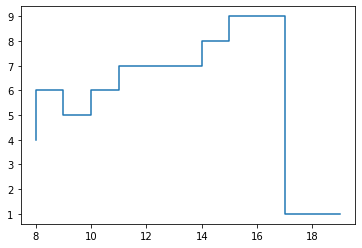

In [15]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [16]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [17]:
sum(hours_prompt['Natężenie'])

0.9999999999999999

## Gry

In [18]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [19]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,Mastermind,planszowa,logiczna,Mastermind to gra znana chyba każdemu fanowi g...,TAK,26.19,NaN,2.0
2,Pędzące Żółwie,planszowa,familijna,Celem gry “Pędzące żółwie” jest doprowadzenie ...,NIE,48.74,NaN,NaN
3,Wirus,karciana,familijna,Waszym zadaniem będzie stawienie czoła epidemi...,NIE,18.49,4.0,NaN
4,Concordia,planszowa,strategiczna,Dwa tysiące lat temu Imperium Rzymskie zajmowa...,NIE,177.00,25.0,NaN


In [20]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [21]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,wagi
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,Mastermind,planszowa,logiczna,Mastermind to gra znana chyba każdemu fanowi g...,TAK,26.19,NaN,2.0,0.044128
2,Pędzące Żółwie,planszowa,familijna,Celem gry “Pędzące żółwie” jest doprowadzenie ...,NIE,48.74,NaN,NaN,0.042363
3,Wirus,karciana,familijna,Waszym zadaniem będzie stawienie czoła epidemi...,NIE,18.49,4.0,NaN,0.040669
4,Concordia,planszowa,strategiczna,Dwa tysiące lat temu Imperium Rzymskie zajmowa...,NIE,177.00,25.0,NaN,0.039043


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [22]:
id_generator = lambda n: [*range(1, n+1)]


gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.').apply(lambda x: unidecode_expect_ascii(x))
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False).apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [23]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['city'] = np.full((1, staff.shape[0]), 'Wrocław')[0]
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff.sort_values(by=['updated_at'], inplace=True)
    staff['staff_id'] = id_generator(n)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [24]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
1,1,MIŁOSZ,SZCZĘCH,515147301,MILOSZ.SZCZECH@gazeta.pl,Wrocław,3668.27,False,M,2021-06-01,NaN,2021-06-01 09:28:52
0,2,ŁUKASZ,NOWOCIEŃ,789448599,LUKASZ.NOWOCIEN@yahoo.com,Wrocław,3597.34,False,M,2021-06-01,NaN,2021-06-01 12:36:19
2,3,PAWEŁ,CZARNECKI,738182759,PAWEL.CZARNECKI@allegro.pl,Wrocław,3587.16,False,M,2021-06-01,NaN,2021-06-01 16:36:35
3,4,OLHA,WILCZYŃSKA,456190352,OLHA.WILCZYNSKA@neostrada.pl,Wrocław,3752.07,True,F,2021-06-01,NaN,2021-06-01 18:15:35
4,5,NAZARII,WIESIOŁEK,453973061,NAZARII.WIESIOLEK@neostrada.pl,Wrocław,NaN,False,M,2021-06-01,2022-01-25,2022-01-25 09:52:38
5,6,STANISŁAW,NOWAK,698278896,STANISLAW.NOWAK@gmail.com,Wrocław,3702.42,False,M,2022-02-24,NaN,2022-02-24 15:43:43


## Godziny pracy

In [25]:
def weekday_hour_worker_generator():    
    hours = range(8,20)
    weekdays = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota']

    w = []
    h = []
    for i in hours:
        for j in weekdays:
            w.append(j)
            h.append(i)
    wk = []
    for i in h:
        if i < 14:
            wk.append((1,2))
        else:
            wk.append((3,4,6))
            
    weekday_hour_worker = pd.DataFrame({
        'weekdays': w, 
        'hour': h, 
        'staff': wk
    })
    return weekday_hour_worker

In [26]:
weekday_hour_worker = weekday_hour_worker_generator()
weekday_hour_worker.head()

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"


## Związki

In [27]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [28]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today) + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = id_generator(df.shape[0])
    df['partner_id'] = id_generator(df.shape[0])
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [29]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
8,1,6,M,1,8,2022-04-11 09:50:05
6,2,6,M,2,7,2022-05-12 10:56:07
1,3,4,F,3,3,2022-05-14 16:18:34
2,4,3,M,4,1,2022-07-09 13:30:15
3,5,2,M,5,4,2022-07-20 10:36:38
7,6,3,M,6,3,2022-09-10 08:52:01
4,7,3,M,7,7,2022-10-13 19:21:51
5,8,6,M,8,4,2022-10-27 15:17:10
0,9,4,F,9,5,2023-06-29 08:32:54


## Partnerzy

In [30]:
def partners_df_generator(relationships_df):
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [31]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
8,1,MAJA,F,2022-04-11 09:50:05
6,2,BARBARA,F,2022-05-12 10:56:07
1,3,GRZEGORZ,M,2022-05-14 16:18:34
2,4,MAGDALENA,F,2022-07-09 13:30:15
3,5,AGNIESZKA,F,2022-07-20 10:36:38
7,6,MARZENA,F,2022-09-10 08:52:01
4,7,KAROLINA,F,2022-10-13 19:21:51
5,8,MARTA,F,2022-10-27 15:17:10
0,9,MAREK,M,2023-06-29 08:32:54


## Klienci - część A

In [32]:
customers = pd.DataFrame({'customer_id': id_generator(customers_number)})

## Koszty utrzymania

In [33]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(prompt_dates.loc[(prompt_dates['Data'].dt.day == day) | (prompt_dates['Data'].dt.day == day+1), 'Data'])
    base['flag'] = base['Data'].dt.to_period('M') 
    base.drop_duplicates(['flag'], keep='first', inplace=True)
    base = base.reset_index()
    return base['Data']

In [34]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'CZYNSZ ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'CZYNSZ')[0]
    })
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'ENERGIA ELEKTRYCZNA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df

def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'WODA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'OGRZEWANIE ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat([staff_df[['first_name', 'last_name', 'current_salary']]]*date_df.shape[0], ignore_index=True)
    staff_name = staff_df['first_name'].str.cat(staff_df['last_name'], sep=' ')
    names = pd.concat([staff_name]*date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()['Data']
    title_first = dates.dt.month_name(locale='pl_PL').apply(lambda x: 'PENSJA ' + str(x).upper())
    title = title_first.str.cat(names, sep=' ')
    df = pd.DataFrame({
        'date': dates,
        'title': title,
        'amount': all_staff['current_salary'],
        'type': np.full((1, title.shape[0]), 'PENSJA')[0]
    })
    to_date = pd.to_datetime(staff_df['to_date'].loc[staff_df['to_date'].isnull() == False].values[0])
    df.loc[(df['amount'].isnull() == True) & (df['date'] < to_date), 'amount'] = round(3490 + expon.rvs(scale=100, loc=80), 2)
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame({
        'date': [],
        'title': [],
        'amount': [],
        'type': [],
        'updated_at': []
    })
    df = pd.concat([df, rent_generator(), energy_generator(), water_generator(), heat_generator(), salary_generator(staff)])
    df['updated_at'] = df['date'].apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df.sort_values(by=['updated_at'], inplace=True)
    df['payment_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df['spend_id'] = id_generator(df.shape[0])
    df = df.reindex(['spend_id', 'title', 'amount', 'type','date', 'payment_id', 'invoice_id', 'updated_at'], axis=1)
    return df

In [35]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,CZYNSZ CZERWIEC,3250.00,CZYNSZ,2021-06-05,1,1,2021-06-05 10:20:32
3,2,WODA CZERWIEC,50.28,MEDIA,2021-06-05,2,2,2021-06-05 15:51:16
3,3,ENERGIA ELEKTRYCZNA CZERWIEC,145.52,MEDIA,2021-06-05,3,3,2021-06-05 18:45:21
2,4,PENSJA CZERWIEC PAWEŁ CZARNECKI,3587.16,PENSJA,2021-06-10,4,4,2021-06-10 10:08:47
4,5,PENSJA CZERWIEC NAZARII WIESIOŁEK,3829.34,PENSJA,2021-06-10,5,5,2021-06-10 16:01:41
...,...,...,...,...,...,...,...,...
145,196,PENSJA CZERWIEC ŁUKASZ NOWOCIEŃ,3597.34,PENSJA,2023-06-10,196,196,2023-06-10 08:48:23
147,197,PENSJA CZERWIEC OLHA WILCZYŃSKA,3752.07,PENSJA,2023-06-10,197,197,2023-06-10 12:22:56
146,198,PENSJA CZERWIEC PAWEŁ CZARNECKI,3587.16,PENSJA,2023-06-10,198,198,2023-06-10 15:14:33
144,199,PENSJA CZERWIEC MIŁOSZ SZCZĘCH,3668.27,PENSJA,2023-06-10,199,199,2023-06-10 15:35:23


## Typy wydatków

In [36]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame({
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['expenses_type'], keep='last', inplace=True)
    df.sort_values(by=['updated_at'], inplace=True)
    df['expenses_type_id'] = id_generator(df.shape[0])
    df = df.reindex(['expenses_type_id', 'expenses_type', 'updated_at'], axis=1)
    return df

In [37]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,CZYNSZ,2023-06-05 08:13:57
612,2,MEDIA,2023-06-05 11:38:42
149,3,PENSJA,2023-06-10 19:59:23


## Tytuły wydatków

In [38]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame({
        'title': expense_df['title'],
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['title'], keep='last', inplace=True)
    df = pd.merge(df, expense_types_df[['expenses_type_id', 'expenses_type']], how='left', on=['expenses_type'])
    df.sort_values(by=['updated_at'], inplace=True)
    df['title_id'] = id_generator(df.shape[0])
    df = df.reindex(['title_id', 'title', 'expenses_type_id', 'updated_at'], axis=1)
    return df

In [39]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA CZERWIEC NAZARII WIESIOŁEK,3,2021-06-10 16:01:41
1,2,PENSJA LIPIEC NAZARII WIESIOŁEK,3,2021-07-10 17:06:47
2,3,PENSJA SIERPIEŃ NAZARII WIESIOŁEK,3,2021-08-10 08:06:13
3,4,PENSJA WRZESIEŃ NAZARII WIESIOŁEK,3,2021-09-10 17:03:03
4,5,PENSJA PAŹDZIERNIK NAZARII WIESIOŁEK,3,2021-10-11 13:23:10


## Wydatki i tytuły jeszcze raz

In [40]:
maintenance_expenses2 = pd.merge(maintenance_expenses, expense_titles[['title_id', 'title']], how='left', on='title')
maintenance_expenses2.sort_values(by=['updated_at'], inplace=True)
maintenance_expenses2 = maintenance_expenses2.reindex(['spend_id', 'title_id', 'type', 'amount','payment_id', 'invoice_id', 'updated_at'], axis=1)

In [41]:
maintenance_expenses2.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,102,CZYNSZ,3250.00,1,1,2021-06-05 10:20:32
1,2,103,MEDIA,50.28,2,2,2021-06-05 15:51:16
2,3,104,MEDIA,145.52,3,3,2021-06-05 18:45:21
3,4,107,PENSJA,3587.16,4,4,2021-06-10 10:08:47
4,5,1,PENSJA,3829.34,5,5,2021-06-10 16:01:41


## Turnieje

In [42]:
def game_tournament_generator():
    games = prompt_games.loc[prompt_games['Turniej'] == 'TAK', ['Nazwa', 'rodzaj', 'kategoria']]
    tournament_games = pd.merge(games, prompt_tournaments, left_on=['rodzaj', 'kategoria'], right_on=['Rodzaj', 'Kategoria'], suffixes=['_gry', '_turnieju'])
    tournament_games = tournament_games[['Nazwa_gry', 'Nazwa_turnieju']]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == 'Piątek') & (weekday_hour_worker['hour'] >= 15)]['staff'].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2**x
        x -= 1
    return suma


In [43]:
def tournaments_df_generator():
    dates = pd.DataFrame(prompt_dates.loc[prompt_dates['Dzień tygodnia'] == 'Piątek', 'Data'].iloc[::6]).reset_index()['Data']
    n = dates.shape[0]
    tournament = game_tournament_generator()
    tournament = tournament.sample(n, replace=False, ignore_index=True) #nie może być ten sam wiersz
    tree_levels_number = randint.rvs(2, 4, size=n)
    matches = map(lambda x: count_matches(x), tree_levels_number)
    df = pd.DataFrame({
        'name': tournament['Nazwa_turnieju'],
        'game': tournament['Nazwa_gry'],
        'start_time': dates + datetime.timedelta(hours=15),
        'matches': matches,
        'tree_levels': tree_levels_number,
        'fee': np.full((1, n), 50)[0],
        'sign_up_deadline': dates - datetime.timedelta(days=3) + datetime.timedelta(hours=20),
        'staff_id': [tournament_staff_generator() for i in range(n)],
        'expenses': map(lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=n)),
        'updated_at': dates.apply(lambda x: x + datetime.timedelta(hours=15, minutes=random.randint(1,5), seconds=random.randint(1,59)))
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['tournament_id'] = id_generator(n)
    df['invoice_id'] = id_generator(n)
    df = df.reindex(['tournament_id', 'name', 'game', 'start_time', 'matches', 'tree_levels', 'fee', 'sign_up_deadline', 'staff_id', 'expenses', 'invoice_id', 'updated_at'], axis=1)
    return df

In [44]:
tournaments = tournaments_df_generator()
tournaments.head()

,tournament_id,name,game,start_time,matches,tree_levels,fee,sign_up_deadline,staff_id,expenses,invoice_id,updated_at
0,1,Labirynt Logicznych Umysłów,Mastermind,2021-06-04 15:00:00,15,3,50,2021-06-01 20:00:00,6,204.09,1,2021-06-04 15:03:24
1,2,Krucjata Karcianych Mistrzów,Tajniacy,2021-07-16 15:00:00,7,2,50,2021-07-13 20:00:00,6,207.24,2,2021-07-16 15:04:29
2,3,Krucjata Karcianych Mistrzów,Munchkin,2021-08-27 15:00:00,15,3,50,2021-08-24 20:00:00,3,301.53,3,2021-08-27 15:05:05
3,4,Cytadela Strategii,7 Cudów Świata,2021-10-08 15:00:00,7,2,50,2021-10-05 20:00:00,4,244.94,4,2021-10-08 15:05:39
4,5,Familijna Rewolucja,Monopoly Classic,2021-11-19 15:00:00,15,3,50,2021-11-16 20:00:00,3,246.99,5,2021-11-19 15:04:59


## Udziały

In [45]:
def sign_up_date_generator(deadline):
    deadline = pd.to_datetime(deadline)
    date = pd.to_datetime(prompt_dates['Data'].loc[(prompt_dates['Data'] < deadline) & (prompt_dates['Data'] > deadline - pd.DateOffset(days=14))].sample(1, ignore_index=True).values[0])
    date += pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60)))
    return date

In [46]:
def participations_df_generator(tournament_df, customers_df):
    #liczba uczestników
    players = pd.merge(tournament_df[['game', 'tree_levels', 'tournament_id', 'fee', 'sign_up_deadline']], prompt_games[['Nazwa', 'Liczba uczestników']], left_on=['game'], right_on=['Nazwa'], how='left')
    players['Liczba uczestników'] = players['Liczba uczestników'].astype('int')
    players_number = players['Liczba uczestników'] * (2**players['tree_levels'])
    players['players'] = players_number

    #customer_id i miejsce
    participants = map(lambda x: customers_df['customer_id'].sample(x, replace=False, ignore_index=True).values, players_number)
    players['place'] = players['players'].apply(lambda x: [*range(1, x+1)])
    players['customer_id'] = list(participants)

    #ostateczny df
    df = players[['tournament_id', 'customer_id', 'fee', 'sign_up_deadline', 'place']]
    df = df.explode(['customer_id', 'place'], ignore_index=True)
    df['sign_up_date'] = df['sign_up_deadline'].apply(lambda x: sign_up_date_generator(x))
    df['updated_at'] = df['sign_up_date'].copy()
    df.sort_values(by=['updated_at'], inplace=True)
    df['particip_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df = df.reindex(['particip_id', 'tournament_id', 'customer_id', 'place', 'sign_up_date', 'fee', 'invoice_id', 'updated_at'], axis=1)
    return df

In [47]:
participations = participations_df_generator(tournaments, customers)
participations.head()

,particip_id,tournament_id,customer_id,place,sign_up_date,fee,invoice_id,updated_at
15,1,1,310,16,2021-06-01 08:00:39,50,1,2021-06-01 08:00:39
13,2,1,1385,14,2021-06-01 08:15:51,50,2,2021-06-01 08:15:51
14,3,1,549,15,2021-06-01 10:30:48,50,3,2021-06-01 10:30:48
7,4,1,1181,8,2021-06-01 10:38:38,50,4,2021-06-01 10:38:38
6,5,1,668,7,2021-06-01 10:54:29,50,5,2021-06-01 10:54:29


## Magazyn

In [48]:
def get_value_from_another_column(df, search_column, search_value, target_column):
    matching_rows = df.loc[df[search_column] == search_value]
    target_value = matching_rows[target_column].values[0]
    return target_value


def sell(): 
    N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    while N < 2500 or N > 3700: 
        N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    ilość = list(map(round,prompt_games['wagi']*N))
    M = [prompt_games['Nazwa'][i:i+5] for i in range(0, len(prompt_games['Nazwa']), 5)]
    daty = []
    datysklepowe = list(prompt_dates['Data'].dt.strftime('%Y-%m-%d'))
    ilość2 = [sum(ilość[i:i+5]) for i in range(0,51,5)]
    for i in range(len(M)):
        d = max(len(M) + round(norm.rvs(0,5)),1)
        day = datetime.datetime(random.choice(range(2021,2024)),random.choice(range(1,13)),d).strftime("%Y-%m-%d")
        while day not in datysklepowe:
            day = datetime.datetime(random.choice(range(2021, 2024)), random.choice(range(1, 13)), d).strftime("%Y-%m-%d")
        daty.append(day)
    index = [x for x, y in zip(range(1,len(M)+1), ilość2) for _ in range(y)]
    indexy = [x for x, y in zip(index, ilość2) for _ in range(y)]
    daty_dost = [x for x, y in zip(daty, ilość2) for _ in range(y)]
    game = [x for x, y in zip(prompt_games['Nazwa'], ilość) for _ in range(y)]
    upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty_dost]
    ceny = [x for x, y in zip(prompt_games['Kupno'], ilość2) for _ in range(y)]
    df = pd.DataFrame({
        'game': game,
        'destination': ['S' for _ in range(len(indexy))],
        'price': ceny,
        'active': [True for i in range(len(upd))],
        'purchase_payment': [round(0.8*cena, 2) for cena in ceny],
        'delivery_date': upd,
        'updated_at': upd
    }) 
    return df


def rental():
    N = 70
    games_r = [random.choice(prompt_games['Nazwa']) for i in range(N)]
    daty = ['2021-06-01' for _ in range(N)]
    daty_upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty]
    df = pd.DataFrame({
        'game': games_r,
        'destination': ['R' for _ in range(N)],
        'price': [round(0.1*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'active': [True for i in range(N)],
        'purchase_payment': [round(0.8*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'delivery_date': daty_upd,
        'updated_at': daty_upd
    }) 
    return df


def games_for_tournament(tournaments_df):
    games_amount = tournaments_df[['game', 'tree_levels']].groupby('game').max().apply(lambda x: 2**x)
    games = pd.merge(games_amount, prompt_games, left_on=['game'], right_on=['Nazwa'])[['tree_levels', 'Nazwa', 'Kupno']]
    n = games.shape[0]
    dates = ['2021-06-01' for _ in range(n)]
    updated = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in dates]
    df = pd.DataFrame({
        'game': games['Nazwa'],
        'destination': ['T' for _ in range(n)],
        'price': [np.nan for i in range(n)],
        'active': [True for i in range(n)],
        'purchase_payment': games['Kupno'],
        'delivery_date': updated,
        'updated_at': updated
    })
    return df


def inventory_df_generator(tournaments_df):
    sell_df = sell()
    rental_df = rental()
    tournament_df = games_for_tournament(tournaments_df)
    df = pd.concat([sell_df, rental_df, tournament_df])
    df.sort_values(by=['updated_at'], inplace=True)
    df['inventory_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df = df.reindex(['inventory_id', 'game', 'destination', 'price', 'active', 'purchase_payment', 'invoice_id', 'delivery_date', 'updated_at'], axis=1)
    return df

In [49]:
inventory = inventory_df_generator(tournaments)
inventory.head()

,inventory_id,game,destination,price,active,purchase_payment,invoice_id,delivery_date,updated_at
36,1,Tajniacy,R,4.99,True,39.92,1,2021-06-01 08:01:28,2021-06-01 08:01:28
48,2,Podaj Łapę,R,13.64,True,109.15,2,2021-06-01 08:08:39,2021-06-01 08:08:39
8,3,Tajniacy,T,NaN,True,49.90,3,2021-06-01 08:12:13,2021-06-01 08:12:13
7,4,Scythe,T,NaN,True,289.00,4,2021-06-01 08:19:32,2021-06-01 08:19:32
66,5,Scythe,R,28.90,True,231.20,5,2021-06-01 08:32:44,2021-06-01 08:32:44


## Ceny gier

In [50]:
def game_prices_df_generator(inventory_df):
    df = inventory_df.drop_duplicates(subset=['price'], keep='last', ignore_index=True)[['price', 'updated_at']]
    df.rename(columns={'price': 'current_price'}, inplace=True)
    df = df.sort_values(['updated_at'])
    df['price_id'] = id_generator(df.shape[0])
    df = df.reindex(['price_id', 'current_price', 'updated_at'], axis=1)
    return df

In [51]:
game_prices = game_prices_df_generator(inventory)
game_prices.head()

,price_id,current_price,updated_at
0,1,3.40,2021-06-01 08:36:59
1,2,4.87,2021-06-01 08:39:07
2,3,13.00,2021-06-01 08:45:52
3,4,5.40,2021-06-01 08:54:48
4,5,4.50,2021-06-01 09:26:14


## Sprzedaże

In [52]:
def sales_df_generator(inventory_df):
    all_date = []
    price = []
    invoice = []
    staff = []
    inventory = []
    for j in range(prompt_dates['Data'].shape[0]):
        for i in range(prompt_dates['volume_sales'][j]):
            hour = random.choices(hours_prompt['Godzina'], weights=hours_prompt['Natężenie'], k=1)[0]
            date = prompt_dates['Data'][j] + datetime.timedelta(hours=int(hour), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            P = random.choices([1, 2, 3], weights=[0.7, 0.25, 0.05])[0]
            games = random.choices(prompt_games['Nazwa'], weights=prompt_games['wagi'], k=P)
            available_staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == date.day_name(locale='pl_PL')) & (weekday_hour_worker['hour'] == date.hour)]['staff'].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            for k in games:
                mask = (inventory_df['game'] == k) & (inventory_df['delivery_date'] < date) & (inventory_df['destination'] == 'S') & (inventory_df['active'] == True)
                if mask.any():
                    inventory_df.loc[mask.idxmax(), 'active'] = False
                    price.append(inventory_df['price'].loc[mask.idxmax()])
                    all_date.append(date)
                    invoice.append(f'{i}_{j}')
                    staff.append(staff_id)
                    inventory.append(inventory_df['inventory_id'].loc[mask.idxmax()])
                    
    df = pd.DataFrame({
        'inventory_id': inventory,
        'price': price,
        'invoice': invoice, 
        'staff_id': staff,
        'date': all_date,
        'return_oper':np.full((1, len(staff)), 'False')[0],
        'updated_at': all_date
    })
    df.sort_values('updated_at', inplace=True)
    df['sale_id'] = id_generator(df.shape[0])
    df = df.reindex(['sale_id', 'inventory_id', 'staff_id', 'price', 'date','invoice','return_oper', 'updated_at'], axis=1)
    return df

In [53]:
sales = sales_df_generator(inventory)

In [54]:
sales.head()

,sale_id,inventory_id,staff_id,price,date,invoice,return_oper,updated_at
0,1,87,2,39.99,2021-11-09 12:47:18,7_136,False,2021-11-09 12:47:18
2,2,84,6,39.99,2021-11-12 15:52:52,7_138,False,2021-11-12 15:52:52
1,3,85,3,39.99,2021-11-12 16:26:32,1_138,False,2021-11-12 16:26:32
3,4,99,4,39.99,2021-11-13 15:14:48,2_139,False,2021-11-13 15:14:48
4,5,101,1,39.99,2021-11-20 10:32:35,13_145,False,2021-11-20 10:32:35


## Rentale

In [55]:
def rental_df_generator(inventory_df):
    rental_date = []
    return_date = []
    customer = []
    price = []
    staff = []
    inventory = []
    rate = []
    update = []
    penalty = []  
    invoice = []
    penalty_invoice = []
    for j in range(prompt_dates['Data'].shape[0]):
        for i in range(prompt_dates['volume_rental'][j]):
            hour = random.choices(hours_prompt['Godzina'], weights=hours_prompt['Natężenie'], k=1)[0]
            date = prompt_dates['Data'][j] + datetime.timedelta(hours=int(hour), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            P = random.choices([1, 2], weights=[0.7, 0.3])[0]
            games = random.choices(prompt_games['Nazwa'], weights=prompt_games['wagi'], k=P)
            available_staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == date.day_name(locale='pl_PL')) & (weekday_hour_worker['hour'] == date.hour)]['staff'].sample(1, replace=True)
            staff_id = random.choice(available_staff.values[0])
            holding_time = gamma.rvs(scale=3, a=2)
            return_date_t = prompt_dates['Data'][j] + datetime.timedelta(days=int(holding_time), hours=round(abs(holding_time)%1*24,2), minutes=random.randint(0, 59), seconds=random.randint(0, 59))
            for k in games:
                mask = (inventory_df['game'] == k) & (inventory_df['delivery_date'] < date) & (inventory_df['destination'] == 'S') & (inventory_df['active'] == True)
                if mask.any():
                    customer.append(int(random.choice(customers['customer_id'])))
                    price.append(inventory_df['price'].loc[mask.idxmax()])
                    rental_date.append(date)
                    staff.append(staff_id)                                          
                    inventory.append(inventory_df['inventory_id'].loc[mask.idxmax()])
                    invoice.append(f'{i}{j}')
                    if return_date_t > datetime.datetime.today():
                        return_date.append(np.nan)
                        update.append(date)
                        inventory_df.loc[mask.idxmax(), 'active'] = False
                        penalty.append(np.nan)
                        penalty_invoice.append(np.nan)
                    else:
                        return_date.append(return_date_t)
                        update.append(return_date_t)
                        delta = return_date_t - date
                        if  delta.days > 3:
                            penalty.append(0.3*get_value_from_another_column(prompt_games,'Nazwa',k,'Wypożyczenie')*delta.days)
                            penalty_invoice.append(f'P{i}_{j}')
                        else:
                            penalty.append(np.nan)
                            penalty_invoice.append(np.nan)
                    rate.append(random.randint(1,10))
   
    df = pd.DataFrame({
        'inventory_id': inventory,
        'customer_id':customer,
        'rental_date': rental_date,
        'return_date': return_date,
        'staff_id': staff,
        'price': price, 
        'invoice': invoice,
        'penalty_payment': penalty,
        'penalty_invoice': penalty_invoice,
        'rate':rate,
        'updated_at': update
    })
    df.sort_values('updated_at', inplace=True)
    df['rental_id'] = id_generator(df.shape[0])
    df = df.reindex(['rental_id', 'inventory_id', 'customer_id', 'rental_date', 'return_date','staff_id','price', 'invoice','penalty_payment', 'penalty_invoice', 'rate', 'updated_at'], axis=1)
    return df


In [56]:
rentals = rental_df_generator(inventory)
rentals.head()

,rental_id,inventory_id,customer_id,rental_date,return_date,staff_id,price,invoice,penalty_payment,penalty_invoice,rate,updated_at
0,1,2596,316,2023-01-14 12:42:33,2023-01-20 20:21:17,1,119.99,5494,25.2,P5_494,7,2023-01-20 20:21:17
1,2,2596,832,2023-01-16 15:20:03,2023-01-21 08:28:27,3,119.99,0495,16.8,P0_495,4,2023-01-21 08:28:27
2,3,2596,774,2023-02-17 15:09:45,2023-02-20 08:38:48,4,119.99,1523,NaN,NaN,7,2023-02-20 08:38:48
3,4,2794,103,2023-03-20 16:06:24,2023-03-23 19:24:32,3,177.00,1549,NaN,NaN,6,2023-03-23 19:24:32
4,5,2773,776,2023-03-21 11:03:18,2023-03-24 20:10:50,1,177.00,2550,NaN,NaN,4,2023-03-24 20:10:50


## Gry

In [57]:
def games_df_generator(inventory_df): 
    update = inventory_df[['game', 'delivery_date']].groupby(['game']).min()
    games = pd.merge(prompt_games, update, left_on=['Nazwa'], right_on=['game'])
    games = games[['Nazwa', 'opis', 'kategoria', 'rodzaj', 'Turniej', 'delivery_date']]
    games.rename(columns={
        'Nazwa': 'title',
        'opis': 'description',
        'kategoria': 'category',
        'rodzaj': 'type',
        'Turniej': 'competitivity',
        'delivery_date': 'updated_at'}, inplace=True)
    games['competitivity'] = games['competitivity'].apply(lambda x: True if x == 'TAK' else False)
    games.sort_values(['updated_at'], inplace=True)
    games['game_id'] = id_generator(games.shape[0])
    games = games.reindex(['game_id', 'title', 'description', 'category', 'type', 'competitivity', 'updated_at'], axis=1)
    return games

In [58]:
games = games_df_generator(inventory)
games.head()

,game_id,title,description,category,type,competitivity,updated_at
35,1,Tajniacy,"Tajniacy próbują odgadnąć, które słowa ich sze...",towarzyska,karciana,True,2021-06-01 08:01:28
15,2,Podaj Łapę,Gracze zostają wolontariuszami schroniska i po...,familijna,karciana,False,2021-06-01 08:08:39
17,3,Scythe,Scythe to gra idealnie łącząca ze sobą mechani...,strategiczna,planszowa,True,2021-06-01 08:19:32
29,4,Super Farmer,Super Farmer to kultowa gra rodzinna o strateg...,familijna,inna,True,2021-06-01 08:36:59
2,5,Pędzące Żółwie,Celem gry “Pędzące żółwie” jest doprowadzenie ...,familijna,planszowa,False,2021-06-01 08:39:07


## Katrgorie gier i typy gier

In [59]:
def game_categories_df_generator(games_df):
    df = games_df[['category', 'updated_at']].drop_duplicates('category', keep='first')
    df.rename(columns={'category': 'game_category'}, inplace=True)
    df['category_id'] = id_generator(df.shape[0])
    df = df.reindex(['category_id', 'game_category', 'updated_at'], axis=1)
    return df


In [60]:
game_categories = game_categories_df_generator(games)
game_categories

,category_id,game_category,updated_at
35,1,towarzyska,2021-06-01 08:01:28
15,2,familijna,2021-06-01 08:08:39
17,3,strategiczna,2021-06-01 08:19:32
37,4,zręcznościowa,2021-06-01 09:26:14
11,5,stretegiczna,2021-06-01 11:25:45
28,6,kolekcjonerska,2021-06-01 12:20:01
38,7,przygodowa,2021-06-01 13:39:22
1,8,logiczna,2021-06-01 15:49:17
24,9,narracyjna,2023-03-17 08:06:16


In [61]:
games['category'] = games['category'].map(dict(zip(game_categories['game_category'], game_categories['category_id'])))

--------

In [62]:
def game_types_df_generator(games_df):
    df = games_df[['type', 'updated_at']].drop_duplicates('type', keep='first')
    df.rename(columns={'type': 'game_type'}, inplace=True)
    df['type_id'] = id_generator(df.shape[0])
    df = df.reindex(['type_id', 'game_type', 'updated_at'], axis=1)
    return df

In [63]:
game_types = game_types_df_generator(games)
game_types

,type_id,game_type,updated_at
35,1,karciana,2021-06-01 08:01:28
17,2,planszowa,2021-06-01 08:19:32
29,3,inna,2021-06-01 08:36:59


In [64]:
games['type'] = games['type'].map(dict(zip(game_types['game_type'], game_types['type_id'])))

## Klienci - część B

In [65]:
def customers_drop(customers, rentals, participations):
    for i in customers['customer_id']:
        if i not in rentals['customer_id'].values and i not in participations['customer_id'].values:
            customers = customers.drop(customers[customers['customer_id'] == i].index)
    return customers

In [66]:
customers = customers_drop(customers, rentals, participations)
customers

,customer_id
2,3
3,4
7,8
10,11
11,12
...,...
1486,1487
1488,1489
1489,1490
1495,1496


In [67]:
merged_df = pd.concat([participations,rentals])

In [68]:
rentals

,rental_id,inventory_id,customer_id,rental_date,return_date,staff_id,price,invoice,penalty_payment,penalty_invoice,rate,updated_at
0,1,2596,316,2023-01-14 12:42:33,2023-01-20 20:21:17,1,119.99,5494,25.2,P5_494,7,2023-01-20 20:21:17
1,2,2596,832,2023-01-16 15:20:03,2023-01-21 08:28:27,3,119.99,0495,16.8,P0_495,4,2023-01-21 08:28:27
2,3,2596,774,2023-02-17 15:09:45,2023-02-20 08:38:48,4,119.99,1523,NaN,NaN,7,2023-02-20 08:38:48
3,4,2794,103,2023-03-20 16:06:24,2023-03-23 19:24:32,3,177.00,1549,NaN,NaN,6,2023-03-23 19:24:32
4,5,2773,776,2023-03-21 11:03:18,2023-03-24 20:10:50,1,177.00,2550,NaN,NaN,4,2023-03-24 20:10:50
...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,2794,159,2023-06-26 11:00:54,NaT,1,177.00,3629,NaN,NaN,8,2023-06-26 11:00:54
57,60,2797,716,2023-06-23 13:49:43,2023-06-27 19:19:09,1,177.00,2627,NaN,P2_627,5,2023-06-27 19:19:09
60,61,2797,1218,2023-06-28 17:49:34,NaT,6,177.00,4631,NaN,NaN,3,2023-06-28 17:49:34
61,62,2746,409,2023-06-28 17:49:34,NaT,6,177.00,4631,NaN,NaN,10,2023-06-28 17:49:34


In [69]:
merged_df['updated_at'] = pd.to_datetime(merged_df['updated_at'])
merged_df = merged_df.groupby('customer_id')['updated_at'].min().reset_index()
customers['updated_at'] = list(merged_df['updated_at'])
customers.sort_values(['updated_at'], inplace=True)
temp = dict(zip(customers['customer_id'], id_generator(len(customers['customer_id']))))
customers['customer_id'] = id_generator(len(customers['customer_id']))
rentals['customer_id'] = rentals['customer_id'].map(temp)
participations['customer_id'] = participations['customer_id'].map(temp)

In [70]:
prompt_cities

,miasto,liczba,prob
0,Bardo,2356,0.001208
1,Bielawa,28344,0.014531
2,Bierutów,4510,0.002312
3,Bogatynia,16245,0.008328
4,Boguszów-Gorce,14349,0.007356
...,...,...,...
87,Ziębice,7995,0.004099
88,Złotoryja,14337,0.007350
89,Złoty Stok,2481,0.001272
90,Żarów,6507,0.003336


In [71]:
def customers_df_generator(customers):
    n = len(customers['customer_id'])
    customers ['gender'] =  [*gender_generator(n)]
    customers['phone'] = [*phone_generator(n)]
    customers['city'] = [random.choices(prompt_cities['miasto'], weights=prompt_cities['prob'])[0] for i in range(n)]
    customers['first_name'] = first_name_generator(customers)
    customers['last_name'] = last_name_generator(customers)
    email_generator(customers)
    customers = customers[['customer_id','first_name','last_name','phone','email','city','updated_at']]
    return customers

In [72]:
customers = customers_df_generator(customers)
customers

,customer_id,first_name,last_name,phone,email,city,updated_at
309,1,PIOTR,TURSKI,575292718,PIOTR.TURSKI9@tlenofon.pl,Wrocław,2021-06-01 08:00:39
1384,2,MARCIN,CZARNECKI,602578540,MARCIN.CZARNECKI3@chello.pl,Jedlina-Zdrój,2021-06-01 08:15:51
548,3,MAGDALENA,LASKOWSKA,886358425,MAGDALENA.LASKOWSKA4@outlook.com,Zgorzelec,2021-06-01 10:30:48
1180,4,MARCIN,STUPAK,514397979,MARCIN.STUPAK6@gazeta.pl,Wrocław,2021-06-01 10:38:38
667,5,RAFAŁ,ŁUSZCZEK,694765740,RAFAL.LUSZCZEK7@yahoo.com,Oława,2021-06-01 10:54:29
...,...,...,...,...,...,...,...
1011,507,IGOR,WILANOWSKI,600113264,IGOR.WILANOWSKI1@polska.pl,Wrocław,2023-06-25 18:03:59
158,508,JOLANTA,ŻUCHOWSKA,793060212,JOLANTA.ZUCHOWSKA6@tlen.pl,Kowary,2023-06-26 11:00:54
408,509,DANUTA,MALISZEWSKA,572826524,DANUTA.MALISZEWSKA1@vp.pl,Wrocław,2023-06-28 17:49:34
1217,510,FILIP,SZPILA,721226385,FILIP.SZPILA7@wp.pl,Wrocław,2023-06-28 17:49:34


## Miasta

In [73]:
def cities():
    merged_df = pd.concat([customers,staff])
    merged_df.sort_values(['updated_at'], inplace=True)
    merged_df.drop_duplicates(subset=['city'], keep='first', inplace=True)
    city = pd.DataFrame({
        'city_id': id_generator(len(merged_df['city'])),
        'city': merged_df['city'],
        'updated_at': merged_df['updated_at']
    })
    return city

In [74]:
city = cities()
city

,city_id,city,updated_at
309,1,Wrocław,2021-06-01 08:00:39
1384,2,Jedlina-Zdrój,2021-06-01 08:15:51
548,3,Zgorzelec,2021-06-01 10:30:48
667,4,Oława,2021-06-01 10:54:29
48,5,Stronie Śląskie,2021-06-01 11:45:08
...,...,...,...
586,69,Karpacz,2022-10-14 14:30:42
1015,70,Niemcza,2022-10-17 11:19:11
1476,71,Jaworzyna Śląska,2022-10-18 10:48:32
1446,72,Pieszyce,2022-11-25 16:17:29


In [75]:
temp = dict(zip(city['city'], city['city_id']))
customers['city'] = customers['city'].map(temp)
staff['city'] = staff['city'].map(temp)
customers.rename(columns={"city": "city_id"})
staff.rename(columns={"city": "city_id"})

<ipython-input-75-e8d8fb55c46e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers['city'] = customers['city'].map(temp)


,staff_id,first_name,last_name,phone,email,city_id,current_salary,is_manager,gender,from_date,to_date,updated_at
1,1,MIŁOSZ,SZCZĘCH,515147301,MILOSZ.SZCZECH@gazeta.pl,1,3668.27,False,M,2021-06-01,NaN,2021-06-01 09:28:52
0,2,ŁUKASZ,NOWOCIEŃ,789448599,LUKASZ.NOWOCIEN@yahoo.com,1,3597.34,False,M,2021-06-01,NaN,2021-06-01 12:36:19
2,3,PAWEŁ,CZARNECKI,738182759,PAWEL.CZARNECKI@allegro.pl,1,3587.16,False,M,2021-06-01,NaN,2021-06-01 16:36:35
3,4,OLHA,WILCZYŃSKA,456190352,OLHA.WILCZYNSKA@neostrada.pl,1,3752.07,True,F,2021-06-01,NaN,2021-06-01 18:15:35
4,5,NAZARII,WIESIOŁEK,453973061,NAZARII.WIESIOLEK@neostrada.pl,1,NaN,False,M,2021-06-01,2022-01-25,2022-01-25 09:52:38
5,6,STANISŁAW,NOWAK,698278896,STANISLAW.NOWAK@gmail.com,1,3702.42,False,M,2022-02-24,NaN,2022-02-24 15:43:43


In [76]:
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
1,1,MIŁOSZ,SZCZĘCH,515147301,MILOSZ.SZCZECH@gazeta.pl,1,3668.27,False,M,2021-06-01,NaN,2021-06-01 09:28:52
0,2,ŁUKASZ,NOWOCIEŃ,789448599,LUKASZ.NOWOCIEN@yahoo.com,1,3597.34,False,M,2021-06-01,NaN,2021-06-01 12:36:19
2,3,PAWEŁ,CZARNECKI,738182759,PAWEL.CZARNECKI@allegro.pl,1,3587.16,False,M,2021-06-01,NaN,2021-06-01 16:36:35
3,4,OLHA,WILCZYŃSKA,456190352,OLHA.WILCZYNSKA@neostrada.pl,1,3752.07,True,F,2021-06-01,NaN,2021-06-01 18:15:35
4,5,NAZARII,WIESIOŁEK,453973061,NAZARII.WIESIOLEK@neostrada.pl,1,NaN,False,M,2021-06-01,2022-01-25,2022-01-25 09:52:38
5,6,STANISŁAW,NOWAK,698278896,STANISLAW.NOWAK@gmail.com,1,3702.42,False,M,2022-02-24,NaN,2022-02-24 15:43:43


## Payments i invoices

In [77]:
def working_payments_df_generator(inventory_df, sales_df, rentals_df, maintenance_expenses_df, tournaments_df, participations_df):
    df_inv = inventory_df[['purchase_payment', 'invoice_id', 'updated_at']].rename(columns={'purchase_payment': 'amount', 'invoice_id': 'invoice', 'updated_at': 'date'})
    df_inv['invoice'] = 'I' + df_inv['invoice'].astype(str)
    df_inv['amount'] = df_inv['amount'] * (-1)
    df_sales = sales_df[['price', 'invoice', 'date']].rename(columns={'price': 'amount'})
    df_sales['invoice'] = 'S' + df_sales['invoice'].astype(str)
    df_rent = rentals_df[['price', 'invoice', 'rental_date']].rename(columns={'price': 'amount', 'rental_date': 'date'})
    df_rent['invoice'] = 'R' + df_rent['invoice'].astype(str)
    df_rent_penalty = rentals_df[['penalty_payment', 'penalty_invoice', 'return_date']].dropna().rename(columns={'penalty_payment': 'amount', 'penalty_invoice': 'invoice', 'return_date': 'date'})
    df_rent_penalty['invoice'] = 'R' + df_rent_penalty['invoice'].astype(str)
    df_exp = maintenance_expenses_df[['amount', 'invoice_id', 'updated_at']].rename(columns={'updated_at': 'date', 'invoice_id': 'invoice'})
    df_exp['invoice'] = 'ME' + df_exp['invoice'].astype(str)
    df_exp['amount'] = df_exp['amount'] * (-1)
    df_tour = tournaments_df[['expenses','invoice_id', 'updated_at']].rename(columns={'expenses': 'amount', 'invoice_id': 'invoice', 'updated_at': 'date'})
    df_tour['invoice'] = 'T' + df_tour['invoice'].astype(str)
    df_tour['amount'] = df_tour['amount'] * (-1)
    df_part = participations_df[['fee', 'invoice_id', 'updated_at']].rename(columns={'fee': 'amount', 'invoice_id': 'invoice', 'updated_at': 'date'})
    df_part['invoice'] = 'P' + df_part['invoice'].astype(str)
    df = pd.concat([df_inv, df_sales, df_rent, df_rent_penalty, df_exp, df_tour, df_part], ignore_index=True)
    return df


In [78]:
working_payments = working_payments_df_generator(inventory, sales, rentals, maintenance_expenses, tournaments, participations)
working_payments.head()

,amount,invoice,date
0,-39.92,I1,2021-06-01 08:01:28
1,-109.15,I2,2021-06-01 08:08:39
2,-49.9,I3,2021-06-01 08:12:13
3,-289.0,I4,2021-06-01 08:19:32
4,-231.2,I5,2021-06-01 08:32:44


In [79]:
def invoices_df_generator(working_payments_df):
    df = working_payments_df[['invoice', 'date']]
    df = df.drop_duplicates('invoice')
    df['updated_at'] = df.loc[:, 'date']
    df['invoice_id'] = id_generator(df.shape[0])
    df = df.reindex(['invoice_id', 'invoice', 'date', 'updated_at'], axis=1)
    return df

In [80]:
invoices = invoices_df_generator(working_payments)
invoices.head()

,invoice_id,invoice,date,updated_at
0,1,I1,2021-06-01 08:01:28,2021-06-01 08:01:28
1,2,I2,2021-06-01 08:08:39,2021-06-01 08:08:39
2,3,I3,2021-06-01 08:12:13,2021-06-01 08:12:13
3,4,I4,2021-06-01 08:19:32,2021-06-01 08:19:32
4,5,I5,2021-06-01 08:32:44,2021-06-01 08:32:44


In [81]:
def payments_df_generator(working_payments_df, invoices_df):
    df = pd.merge(working_payments_df, invoices_df, on='invoice')[['amount', 'invoice_id', 'updated_at']]
    df['payment_id'] = id_generator(df.shape[0])
    df = df.reindex(['payment_id', 'amount', 'invoice_id', 'updated_at'], axis=1)
    return df

In [82]:
payments = payments_df_generator(working_payments, invoices)
payments.head()

,payment_id,amount,invoice_id,updated_at
0,1,-39.92,1,2021-06-01 08:01:28
1,2,-109.15,2,2021-06-01 08:08:39
2,3,-49.9,3,2021-06-01 08:12:13
3,4,-289.0,4,2021-06-01 08:19:32
4,5,-231.2,5,2021-06-01 08:32:44


------

# Faza 3 - ostateczne tabele

In [ ]:
payments['amount'].sum()

In [83]:
# Tabela city
city 

#Tabela customers
customers

#Tabela participations
participations

#Tabela tournaments
tournaments['game'] = tournaments['game'].map(dict(zip(games['title'], games['game_id'])))
tournaments = tournaments.rename(columns={'game':'game_id','expenses':'expenses_payments_id'})
tournaments = tournaments.drop(columns=['tree_levels'])

#Tabela rental
rental = rentals.rename(columns={'penalty_payment':'penalty_payment_id','price':'payment_id'})

#Tabela inventory
inventory['game'] = inventory['game'].map(dict(zip(games['title'], games['game_id'])))
inventory = inventory.rename(columns={'game':'game_id','price':'price_id','purchase_payment':'purchase_payment_id'})

#Tabela staff
staff

#Tabela relationships
relationships = relationships.drop(columns=['staff_gender'])

#Tabela partners
partners

#Tabela payments
payments 

#Tabela invoices
invoices = invoices.drop(columns=['invoice'])

#Tabela maintenance_expenses
maintenance_expenses['title'] = maintenance_expenses['title'].map(dict(zip(expense_titles['title'], expense_titles['title_id'])))
maintenance_expenses = maintenance_expenses.drop(columns=['invoice_id','amount','type'])
maintenance_expenses = maintenance_expenses.rename(columns={'title':'title_id'})

#Tabela expense_titles
expense_titles

#Tabela expense_types
expense_types

#Tabela sales
sales = sales.rename(columns={'price':'payment_id'})

#Tabela games
games = games.rename(columns={'category':'category_id','type':'type_id'})

#Tabela game_categories
game_categories

#Tabela game_types
game_types

#Tabela game_prices
game_prices

,price_id,current_price,updated_at
0,1,3.40,2021-06-01 08:36:59
1,2,4.87,2021-06-01 08:39:07
2,3,13.00,2021-06-01 08:45:52
3,4,5.40,2021-06-01 08:54:48
4,5,4.50,2021-06-01 09:26:14
5,6,4.49,2021-06-01 10:00:40
6,7,31.60,2021-06-01 10:26:25
7,8,11.93,2021-06-01 10:29:26
8,9,8.15,2021-06-01 10:49:29
9,10,11.99,2021-06-01 11:25:45
